# Adventure Works Database Python Functions
The following code is a collection of functions that collect various types of data from the AdventureWorks2019 database using Microsoft SQL Server queries.

In [2]:

import pyodbc
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Connect to database and SQL Server
def HandleHierarchyId(v):
      return str(v)

conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                      'SERVER=localhost;' 
                      'DATABASE=AdventureWorks2019;' 
                       'Trusted_connection=yes;')

conn.add_output_converter(-151, HandleHierarchyId)             
 
cursor = conn.cursor()

This function goes retrieves the names that are in each organization level and returns them in a dataframe.

In [54]:
def getOrgLevelnames(level):
    
    firstNames = []
    lastNames = []
    IDs = []
    names = []
    addr = []
    IDNames = {}
    if int(level) not in range (1,5):
        print('That level is not in the company')
        return null
    else:
        cursor.execute('''select FirstName, LastName, P.BusinessEntityID, AddressLine1, City, Name
                          FROM Person.Person P,HumanResources.Employee HD,Person.Address PA,Person.BusinessEntityAddress PB,
                          Person.StateProvince PS
                          Where HD.OrganizationLevel = ? AND P.BusinessEntityID = HD.BusinessEntityID 
                          AND PB.AddressID = PA.AddressID  AND P.BusinessEntityID = PB.BusinessEntityID
                          AND PS.StateProvinceID = PA.StateProvinceID
                        ''', level)
    for row in cursor:
        #print('Name: ' , row)
        
        firstNames.append(row[0])
        lastNames.append(row[1])
        names.append(row[0] + ' '+ row[1])
        IDs.append(row[2])
        #IDNames[row[2]] = row[0] + ' ' + row[1]
        addr.append(row[3] + ' ' + row[4] + ', ' + row[5])
    addr_df = pd.DataFrame({'Entity ID': IDs, 'Employee Name': names, 'Address': addr})
    
    return addr_df
orgLevel = input("What organization level do you want to see names for?\n")
getOrgLevelnames(orgLevel)

What organization level do you want to see names for?
4


,Entity ID,Employee Name,Address
0,8,Diane Margheim,"475 Santa Maria Everett, Washington"
1,9,Gigi Matthew,"7808 Brown St. Bellevue, Washington"
2,10,Michael Raheem,"1234 Seaside Way San Francisco, California"
3,12,Thierry D'Hers,"1970 Napa Ct. Bothell, Washington"
4,13,Janice Galvin,"3397 Rancho View Drive Redmond, Washington"
...,...,...,...
185,257,Eric Kurjan,"1378 String Dr Renton, Washington"
186,258,Erin Hagens,"2947 Vine Lane Bellevue, Washington"
187,259,Ben Miller,"101 Candy Rd. Redmond, Washington"
188,260,Annette Hill,"6369 Ellis Street Redmond, Washington"


This function etrieves all salaries in the company and returns them in a dataframe

In [50]:
def getAllSalaries():
    names = []
    rates = []  
    cursor.execute('''SELECT FirstName, LastName, P.BusinessEntityID, Rate 
                   FROM Person.Person P,HumanResources.EmployeePayHistory HE
                   WHERE P.BusinessEntityID = HE.BusinessEntityID
                   ORDER BY Rate DESC''')
    
    for row in cursor:
        names.append(row[0] + ' ' + row[1])
        
        rates.append(round(row[3], 2))
    rate_df = pd.DataFrame({"Employee Name": names, "Pay Rate": rates})
    return rate_df
getAllSalaries()

,Employee Name,Pay Rate
0,Ken Sánchez,125.50
1,James Hamilton,84.13
2,Brian Welcker,72.12
3,Terri Duffy,63.46
4,Laura Norman,60.10
...,...,...
311,John Frum,6.50
312,David Johnson,6.50
313,Marc Ingle,6.50
314,Reed Koch,6.50


This function returns how much a person given their name as a parameter

In [46]:
def getRate(name):
        cursor.execute('''SELECT FirstName, LastName,P.BusinessEntityID,Rate
                   FROM Person.Person P,HumanResources.EmployeePayHistory HE
                   WHERE P.BusinessEntityID = HE.BusinessEntityID
                   ORDER BY P.BusinessEntityID''')
        for row in cursor:
            
            fullName = row[0] + ' ' + row[1]
        
            if fullName == name:
                rate = str(round(row[3], 2))
                return rate
        return "Name not found"
getRate("Terri Duffy")

'63.46'

This function returns the pay rate history by year for a position or area of work. It also returns a line graph showing this area or position's pay rate history if the company had the it created for more than 1 year. Its purpose is to show reflection on how often the company would promote its employees, where job promotions lead to pay raises, increasing its yearly average. 


What job or department would you like to see payment history on?
Sales

Pay Rate history for Sales

Last payrate recorded in year  2013 

Average pay rate in 2011 (11 reported rate changes):  29.81
Average pay rate in 2012 (15 reported rate changes):  29.68

Current average pay rate (18 reported rate changes):  29.97
First year position was hired: 2011 

Last year position was hired: 2013 



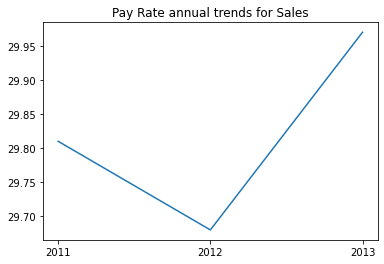

In [7]:
def payRateHistorybyPosition(userJobChoice,currentYear = 2013):

    payDates = []
    rates = []  
    
    currentYear = 2013

    rateTotalJob = 0
    jobCount = 0

    yearsWorked = 0
    print("\nPay Rate history for "+ userJobChoice) 
    if(len(userJobChoice) >=5):

        cursor.execute('''SELECT DISTINCT P.BusinessEntityID, FirstName, LastName,Rate, JobTitle, RateChangeDate
                   FROM Person.Person P,HumanResources.EmployeePayHistory HEP, HumanResources.Employee HE
                   WHERE P.BusinessEntityID = HEP.BusinessEntityID  AND HE.BusinessEntityID = P.BusinessEntityID AND
				   JobTitle LIKE CONCAT('%',?,'%')
                   ORDER BY RateChangeDate ASC;''', userJobChoice) 
    else:
        print("Invalid Entry/Job not found in database")
        return 0

        


    for row in cursor:
        datetime = str(row[5])
        year = datetime[:4]
        payDates.append(year)
        rates.append(row[3])

    k=0
    yearAvgs = []
    yearAvg = {}
    years = []

    try:

       
        print("\nLast payrate recorded in year ", currentYear, "\n")
        for j in range(len(payDates)):
   
                try:
                    if payDates[j] != payDates[j+1]:
                            if j == 0:
                                k+=1
                                print("Average pay rate in", payDates[j], "("+str(len(payDates[:k]))+" reported rate changes): ",
                                      round(sum(rates[:k])/len(rates[:k]), 2))
                                yearAvgs.append(round(sum(rates[:k])/len(rates[:k]), 2))
                                years.append(payDates[j])
                            else:
                                print("Average pay rate in", payDates[j], "("+str(len(payDates[:k]))+" reported rate changes): ",  
                                      round(sum(rates[:k])/len(rates[:k]), 2))
                                yearAvgs.append(round(sum(rates[:k])/len(rates[:k]), 2))
                                years.append(payDates[j])
                    elif j == 0:
                        k += 1
                except IndexError:
                    print("\nCurrent average pay rate ("+str(len(payDates[:k]))+" reported rate changes): ", 
                          round(sum(rates[:k])/len(rates[:k]), 2))
                    yearAvgs.append(round(sum(rates[:k])/len(rates[:k]), 2))
                    years.append(payDates[j])
                k += 1 
        print("First year position was hired:", payDates[0], "\n")
        print("Last year position was hired:", payDates[-1], "\n")
        if(len(years)>1):
            yearAvgs = {'Year': years, 'Avg': yearAvgs}
            df  = pd.DataFrame(data=yearAvgs)
            df.head()
            plt.title("Pay Rate annual trends for "+ userJobChoice)
            plt.plot("Year", "Avg", data=df)
            plt.show()
        else:
            print("No other payrates to report")
    except IndexError:
        print("Job not found in Database")
        print('''Note: Some jobs require further specification, i.e Production Technician should be something like... 
               Production Technician-WC-10''')

jobChoice = input("\nWhat job or department would you like to see payment history on?\n")
payRateHistorybyPosition(jobChoice)


    